### Import

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import wave
import sys
import torchaudio
import librosa
import numpy as np
from scipy.io.wavfile import write
import IPython
from collections import Counter
import sounddevice as sd
from math import ceil

%matplotlib inline

### Read / Record

In [2]:
t = 'أَرْبَعَة، عَدَمْ تَحْمِيلْ أَيِّ مَوَادْ أَوْ مَعْلُومَاتْ أَوْ مَلَفَّاتْ تَحْتَوِي عَلَىْ ب^َرْمَجِيَّاتْ أَوْ مَوَادْ أُخْرَى مَحْمِيَّة بِقَوَانِينْ الْمِلْكِيَّة اْلْفِكْرِيَّة، أَوْ بِحِقُوقْ خُصُوْصِيِّةْ النَّشْرِ مَا لَمْ يَكُنْ مَالِكًا لَهَا وَ لِحُقُوقِهَا، أَوْ صَاحِبْ السَّيْطَرَة عَلَىْ حُقُوقِهَا، أَوْ لَدَيْهِ جَمِيعْ الْمُوَافَقَاتْ اللَّازِمَة لِعَمَلِ ذَلِكْ .'
t1 = 'أَنَاْ بَعْتِزِرْ لِح^َضْرِت^َكْ يَاْ فَنْدِمْ، مَفِيشْ رَصِيدْ كَافِي لْتَجْدِيدْ ب^َاقِةْ فِلِيْكْسْ، يَاْر<يتْ نِشْحِنْ بِ جِن<يه، وُ اطْلُبْ كُودْ نِجْمَة مِت<ينْ خ^َمْسَة وْعِشْرِينْ شِبَّاكْ، عَشَانْ تِجَدِّدْ ب^َاقِةْ فِلِيْكْسْ الْخَاصَّة بْخَطَّكْ، وِالْب^َاقَة هَتِتْجَدِّدْ تِلْقَائِيًّا خِلَالْ عِشْرِينْ دِقِيقَة، وِلَوْ حَابِبْ فِ أَيِّ وَقْتِ تِعْرَفْ تَارِيخْ تَجْدِيدْ ب^َاقِةْ فِلِيْكْسْ مُمْكِنْ عَنْ طَرِيقْ ت^َطْبِيقْ أَنَا فُدَف>ونْ .'
t2 = 'أَنَاْ رَاْجِعْتِ حْسَابْ ح^َضْرِت^َكْ، وِح^َضْرِت^َكْ بِالْفِعْلِ بْتِسْتَمْتِعْ بِخِدْمِةْ الْوَاتْسَابْ الْمَجَّانِيَّة، وِدِي بْتِدِّي لْح^َضْرِت^َكْ مِت<ينْ م<يجَا بِالسُّرْع^َة اْلْعَادِيَّة، وِفْ حَالْ انْتِهَاءْ مِت<ينْ م<يجَا هَتْقِلّْ السُّرْع^َة، وِلَوْ حَابِبْ تَسْتَرِدّْ السُّرْع^َة بَعْدْ انْتِهَاءْ مِت<ينْ م<يجَا هَتِطْلُبْ الْكُودْ، نِجْمَة تُمْنُمِيَّة وْتَمَاْنِينْ نِجْمَة وَاحِدْ وِخ^َمْسِينْ شِبَّاكْ، وِهَيْتِمِّ مُحَاْسْبِتَكْ حَسَبْ نِظَام^َكْ، هَلْ تَرْغ^َبْ ؟'

In [9]:
wave_arr , sr = librosa.load("output.wav")
wave_arr.shape, sr

((553984,), 22050)

### Count silence

In [25]:
s = 0 ; peaks_All = [] ; pos = []

while(s<len(wave_arr)):
    arr = (abs(wave_arr[s:s+500])*1000).astype(int)
    zero_percent = len([a for a in arr if (a<=5)])/len(arr)*100
    if(zero_percent<=50):
        peaks_All.append(zero_percent)
    else:
        peaks_All.append(0)
    pos.append(s)
    s = s + 500

### Detect beginning of wave

In [26]:
peaks_Begin = []
for i in range(len(peaks_All)-1):
    if((int(peaks_All[i]==0)) and (int(peaks_All[i+1]!=0))):
        peaks_Begin.append(pos[i])

### Remove noise & near splits

In [27]:
#remove false splits  @ noise
pos_last = []
for i in range(len(peaks_Begin)-1):
    if(int(np.max(wave_arr[peaks_Begin[i]:peaks_Begin[i+1]])*10) > 0):
        pos_last.append(peaks_Begin[i])
pos_last.append(peaks_Begin[-1])
pos_last.append(len(wave_arr))

#remove near peaks
pos_lastt = []
for i in range(len(pos_last)-1):
    if(abs(pos_last[i]-pos_last[i+1]) >= sr/4):
        pos_lastt.append(pos_last[i])

pos_lastt.append(pos_last[-1])

### Plot

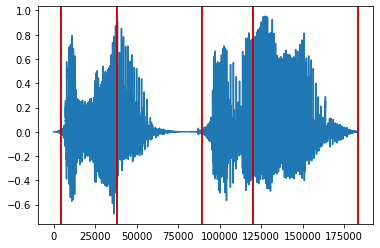

In [28]:
plt.plot(wave_arr[:])
for i in range(len(pos_last)):
    plt.axvline(x=pos_last[i],color="black")
for i in range(len(pos_lastt)):
    plt.axvline(x=pos_lastt[i],color="red")
plt.show()

### Write splits

In [29]:
# delete last ones
import os, shutil
folder = 'splits/'
for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

In [30]:
for n in range(len(pos_lastt)-1):
    write("splits/split_"+ str(n) + ".wav", sr, wave_arr[pos_lastt[n]:pos_lastt[n+1]])
    n+=1

In [31]:
import os
p = "splits/"
splits_paths = [p+i for i in os.listdir(p)]

for  i in splits_paths:
    print(i ,  " : ", librosa.get_duration(filename=i))

splits/split_0.wav  :  1.5192743764172336
splits/split_1.wav  :  2.3356009070294785
splits/split_2.wav  :  1.383219954648526
splits/split_3.wav  :  2.877596371882086
